# jammer
## 12 Extract, transform, and load the full-sampling Gl570D data
### I- Data for Starfish

Michael Gully-Santiago  
Thursday, March 27, 2017

In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
% config InlineBackend.figure_format = 'retina'
import seaborn as sns

In [2]:
from astropy.io import fits
import h5py

In [3]:
import astropy.units as u

In [4]:
from os import listdir

In [5]:
file = '../../../other_GitHub/splat/reference/Spectra/10020_11100.fits'

In [6]:
fits_dat = fits.open(file)
fd_0 = fits_dat[0]
fd_0.data.shape

(3, 560)

In [7]:
with open('../data/raw/Gl570D.pic', 'rb') as f:
    wlgrid_orig, Flux_orig, Flux_err_orig = np.load(f, allow_pickle=True, encoding='bytes')

It seems like the default SpeX Prism Library spectrum is normalized to its peak.

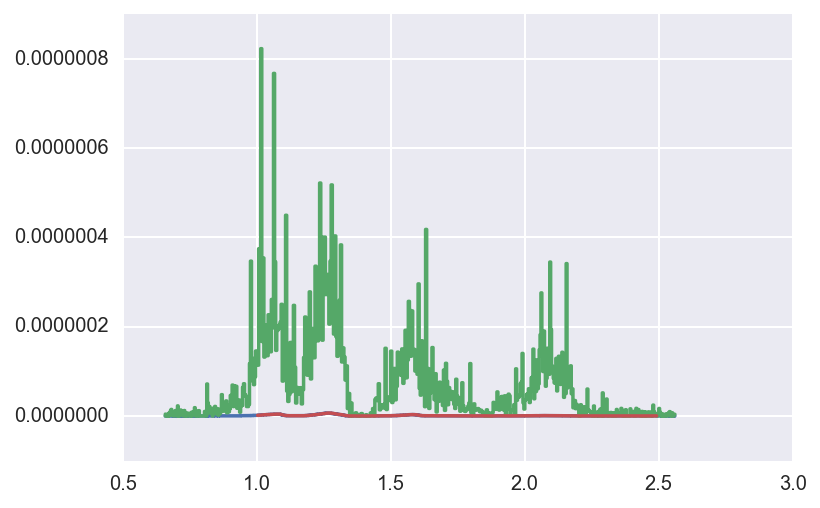

In [ ]:
plt.step(fd_0.data[0, :], fd_0.data[1, :]*np.max(Flux_orig))
plt.step(fd_0.data[0, :], fd_0.data[2, :]*np.max(Flux_orig))
plt.plot(wlgrid_orig, Flux_orig, '-')

Also, the third column looks like $S/N$ not just $N$, unless I'm mistaken.  Weird.

In [ ]:
plt.plot(fd_0.data[0, :],  fd_0.data[1, :]/fd_0.data[2, :], 'o')
plt.ylabel('$\sigma ?$')

We need to convert the units to what Starfish expects:
- **wavelengths:** Angstroms
- **fluxes:** erg/s/cm$^2$/A

update 4/21/2017:
Some sigmas have negative or zero values!!!  Fix this!

In [ ]:
wlgrid = fd_0.data[0, :]
Flux = fd_0.data[1, :]*np.max(Flux_orig)
Flux_err = np.abs(fd_0.data[1, :]/fd_0.data[2, :])*np.max(Flux_orig)

In [ ]:
plt.step(wlgrid, Flux)
plt.plot(wlgrid, Flux_err)

In [ ]:
plt.plot(wlgrid, Flux/Flux_err, '.')

Let's enforce $S/N <75$ and $\sigma \ne 0$.  
That is, $N=S/75$.

In [ ]:
bi = ((Flux/Flux_err) > 75)

In [ ]:
bi.sum()

In [ ]:
Flux_err[bi] = Flux[bi]/75.0

In [ ]:
bi2 = np.abs(Flux_err) == np.inf
Flux_err[bi2] = np.abs(Flux[bi2]*3.0)

In [ ]:
out_name = '../data/reduced/Gl570D_full.hdf5'
fls_out = (Flux*u.Watt/u.m**2/u.m).to(u.erg/u.s/u.cm**2/u.Angstrom).value
sig_out = (Flux_err*u.Watt/u.m**2/u.m).to(u.erg/u.s/u.cm**2/u.Angstrom).value
#print(out_name, np.min(sig_out), np.sum(sig_out==0), np.percentile(fls_out/sig_out, 80))
bi = sig_out <= 0
sig_out[bi] = np.abs(fls_out[bi])
wls_out = wlgrid*10000.0
msk_out = np.ones(len(wls_out), dtype=int)
f_new = h5py.File(out_name, 'w')
f_new.create_dataset('fls', data=fls_out)
f_new.create_dataset('wls', data=wls_out)
f_new.create_dataset('sigmas', data=sig_out)
f_new.create_dataset('masks', data=msk_out)
print("{:.0f}  -  {:.0f}   {}".format(wls_out[0], wls_out[-1], out_name))
f_new.close()

### The end!